# original

https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

# special

- almost all are one hot encoding
- many features

# score

cv score for all training set is not so high. 0.8383838383838383
it is below my current best score 2018/04/01.


# columns

Index(['Survived', 'Age', 'Fare', 'Name_Len', 'Age_Null_Flag',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Ticket_Len', 'Pclass_3', 'Pclass_1',
       'Pclass_2', 'Sex_male', 'Sex_female', 'Embarked_S', 'Embarked_C',
       'Embarked_Q', 'Ticket_Lett_A', 'Ticket_Lett_P', 'Ticket_Lett_S',
       'Ticket_Lett_1', 'Ticket_Lett_3', 'Ticket_Lett_2', 'Ticket_Lett_C',
       'Ticket_Lett_Low_ticket', 'Ticket_Lett_Other_ticket', 'Cabin_Letter_n',
       'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D',
       'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Name_Title_Mr.',
       'Name_Title_Mrs.', 'Name_Title_Miss.', 'Name_Title_Master.',
       'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.',
       'Name_Title_Col.', 'Fam_Size_Nuclear', 'Fam_Size_Solo', 'Fam_Size_Big'],
      dtype='object')

# else

	variable	importance
12	Sex_female	0.111215
11	Sex_male	0.109769
33	Name_Title_Mr.	0.109746
1	Fare	0.088209
2	Name_Len	0.087904
0	Age	0.078651
8	Pclass_3	0.043268
35	Name_Title_Miss.	0.031292
7	Ticket_Len	0.031079
34	Name_Title_Mrs.	0.028852
25	Cabin_Letter_n	0.027893
43	Fam_Size_Big	0.025199
41	Fam_Size_Nuclear	0.022704
9	Pclass_1	0.021810
19	Ticket_Lett_1	0.017999
20	Ticket_Lett_3	0.012902
10	Pclass_2	0.012345
36	Name_Title_Master.	0.012098
23	Ticket_Lett_Low_ticket	0.011723
13	Embarked_S	0.011546



In [32]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [33]:
# Utility function to report best scores
def report(results, n_top=3):
    """Utility function to report best scores
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Rank: {0}".format(i))
            print("Score: {0:f} (std: {1:f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Pars: {0}".format(results['params'][candidate]))
            print("")
            

def report2(results, n_top=3):
    """Utility function to report best scores
    """
    print("Rank|Score(std)|Params", list(results['params'][0].keys()))
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("{0}|".format(i), end="")
            print("{0:f}(std:{1:f})|".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]), end="")
            print("{0}".format(list(results['params'][candidate].values())))

In [34]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test


def fam_size(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test


def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test


def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test


def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test


train = pd.read_csv(os.path.join('../input', 'train.csv'))
test = pd.read_csv(os.path.join('../input', 'test.csv'))
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train, test)
train, test = cabin(train, test)
train, test = embarked_impute(train, test)
train, test = fam_size(train, test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train, test)
train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = drop(train, test)

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_features='auto', oob_score=True, random_state=1, n_jobs=3)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10], 
              "min_samples_split" : [2, 4, 10, 12, 16],
              "n_estimators": [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', 
                  cv=3, n_jobs=6, verbose=1)

gs = gs.fit(train.iloc[:, 1:], train.iloc[:, 0])

print(gs.best_score_)
print(gs.best_params_)
print(gs.cv_results_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   36.3s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 450 out of 450 | elapsed:  1.5min finished


0.8383838383838383
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 700}
{'mean_fit_time': array([0.23539925, 0.33712943, 0.80466318, 1.52326751, 2.00184425,
       0.17175182, 0.22084697, 0.78224889, 1.39152304, 1.83824134,
       0.16723434, 0.20508679, 0.84553933, 1.32509335, 1.77881598,
       0.17081602, 0.20941639, 0.79459302, 1.30329251, 1.80821745,
       0.16890256, 0.20205522, 0.72184642, 1.33989016, 1.7373414 ,
       0.16834307, 0.2179021 , 0.77509522, 1.35552971, 1.68355417,
       0.15951784, 0.20614894, 0.78354462, 1.25358796, 1.88760201,
       0.18347692, 0.20698452, 0.74847523, 1.32237927, 1.81297882,
       0.17015107, 0.21768355, 0.76765545, 1.17944884, 1.83665284,
       0.16612903, 0.21771232, 0.71689423, 1.36948991, 1.78488994,
       0.17578101, 0.19873563, 0.7647051 , 1.32978241, 1.73306211,
       0.16512211, 0.22019458, 0.74051412, 1.25883142, 1.77190924,
       0.15898236, 0.18706004, 0.80248117, 1.32517234, 1.77281531,
 

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8294


----

In [37]:
print("best parameters:", gs.best_params_)
print("Mean cross-validated score of the best_estimator: ", gs.best_score_)
print("")
report2(gs.cv_results_, n_top=10)

best parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 700}
Mean cross-validated score of the best_estimator:  0.8383838383838383

Rank|Score(std)|Params ['criterion', 'min_samples_leaf', 'min_samples_split', 'n_estimators']
1|0.838384(std:0.018027)|['gini', 1, 10, 700]
1|0.838384(std:0.016495)|['gini', 1, 10, 1000]
1|0.838384(std:0.009912)|['entropy', 1, 4, 400]
1|0.838384(std:0.009912)|['entropy', 1, 12, 50]
5|0.837262(std:0.013561)|['gini', 1, 4, 50]
5|0.837262(std:0.004199)|['gini', 1, 4, 100]
5|0.837262(std:0.011111)|['gini', 1, 4, 700]
5|0.837262(std:0.016798)|['entropy', 1, 12, 1000]
9|0.836139(std:0.011446)|['gini', 1, 4, 400]
9|0.836139(std:0.009655)|['gini', 1, 4, 1000]
9|0.836139(std:0.022050)|['entropy', 1, 4, 100]
9|0.836139(std:0.009655)|['entropy', 1, 4, 700]
9|0.836139(std:0.019888)|['entropy', 1, 16, 100]


In [38]:
train.columns

Index(['Survived', 'Age', 'Fare', 'Name_Len', 'Age_Null_Flag',
       'Cabin_num_(1.999, 28.667]', 'Cabin_num_(28.667, 65.667]',
       'Cabin_num_(65.667, 148.0]', 'Ticket_Len', 'Pclass_3', 'Pclass_1',
       'Pclass_2', 'Sex_male', 'Sex_female', 'Embarked_S', 'Embarked_C',
       'Embarked_Q', 'Ticket_Lett_A', 'Ticket_Lett_P', 'Ticket_Lett_S',
       'Ticket_Lett_1', 'Ticket_Lett_3', 'Ticket_Lett_2', 'Ticket_Lett_C',
       'Ticket_Lett_Low_ticket', 'Ticket_Lett_Other_ticket', 'Cabin_Letter_n',
       'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D',
       'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Name_Title_Mr.',
       'Name_Title_Mrs.', 'Name_Title_Miss.', 'Name_Title_Master.',
       'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.',
       'Name_Title_Col.', 'Fam_Size_Nuclear', 'Fam_Size_Solo', 'Fam_Size_Big'],
      dtype='object')

In [39]:
pd.concat((pd.DataFrame(train.columns, columns = ['variable']), 
           pd.DataFrame(gs.best_estimator_.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
12,Sex_male,0.111215
11,Pclass_2,0.109769
33,Cabin_Letter_F,0.109746
1,Age,0.088209
2,Fare,0.087904
0,Survived,0.078651
8,Ticket_Len,0.043268
35,Name_Title_Mrs.,0.031292
7,"Cabin_num_(65.667, 148.0]",0.031079
34,Name_Title_Mr.,0.028852


In [40]:
# get passenger id
_test = pd.read_csv(os.path.join('../input', 'test.csv'))

y_pred = gs.best_estimator_.predict(test).astype(int)

submission = pd.DataFrame({
        "PassengerId": _test["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/_titanic-random-forest-82-78.csv', index=False)

----
----
----

# original

https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever


# special

- family/group survival feature
  - The family/group information is extracted from name, fare and ticket number
  - This new feature improved the score by ~1.5% and put the score to be 0.81818.
  - **this feature express that other member of passenger's family are survived or not.**
    - **this feature doesn't include my survival count.**
- fill age by randint from Age statics

age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
dataset['Age'] = dataset['Age'].astype(int)

- using Rare title for many titles
- **The Fare is actually for the whole family**

  

# score

- 0.81818


# columns

    
# else



In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('../input/train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('../input/test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

print (train.info())

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())


for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())



for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())


for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())


for dataset in full_data:
    dataset['Title'] = [x[1].split(".")[0].strip(" ") for x in dataset['Name'].str.split(",")]

print(pd.crosstab(train['Title'], train['Sex']))

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
   CategoricalFare  Sur

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Extracting family information

- First we can use **last name** to divide the passengers into families. 
- And if you closely examin the data, **same family are paying the same fare** for the tickets. This suggests the fare is for the family. 
- We can use **both last name and fare to grout passengers into families** in case different families with the same last name.
- **The Fare is actually for the whole family**

In [42]:
train_size = len(train)
test_size = len(test)

all_df = train.append(test)
all_df = all_df[list(train.columns)]

all_df.set_index(['PassengerId'], inplace=True) ## This is to make sure of a unique index for both train & test

## Processing family information
all_df['Last name'] = all_df['Name'].apply(lambda x: str.split(x, ",")[0])
all_df['Fare'].fillna(all_df['Fare'].mean(), inplace=True)

# The Fare is actually for the whole family
fare_df = all_df.loc[all_df['FamilySize']>1, ["Last name", "Fare", "FamilySize"]].iloc[:train_size]
fare_diff = (((fare_df.groupby(['Last name', 'FamilySize']).max() 
 - fare_df.groupby(['Last name', 'FamilySize']).min())!=0).sum()/train_size * 100)
print(("Percentage of families with different fares is: %.1f" %(fare_diff.values[0])) + '%')
# The data shows only 1.7% has a different fare value between family memebers. It's some type of anomaly
# Will use last name and fare to group passengers into families
# First would like to show there is value in doing this
train_temp_df = all_df.iloc[:train_size]
family_df_grpby = train_temp_df[train_temp_df['FamilySize']>1][
    ['Last name', 'Fare', 'FamilySize', 'Survived']].groupby(['Last name', 'Fare'])
family_df = pd.DataFrame(data=family_df_grpby.size(), columns=['Size in train'])
family_df['Survived total'] = family_df_grpby['Survived'].sum().astype(int)
family_df['FamilySize'] = family_df_grpby['FamilySize'].mean().astype(int)
#family_df = family_df[family_df['FamilySize']==8]
print("Whole family survived: %.1f" 
      %(100*len(family_df[family_df['Size in train']==family_df['Survived total'] ])/len(family_df))+'%') 
print("Whole family perished: %.1f" 
      %(100*len(family_df[family_df['Survived total'] == 0])/len(family_df))+'%') 
## Majority family either all perished or all survived, this means we can use this as one feature to 
## predict survival

# Now let's do the feature extraction
# Intialize all 'Family survival', meaning there is no information on if any family members survived. 
# This number can be tuned I guess but I will use it to start with.
grp_partial_age = 0
grp_partial_cabin = 0
grp_age_diff_df = pd.DataFrame()
all_df['Family survival'] = 0.5
for grp, grp_df in all_df[['Survived','Name', 'Last name', 'Fare', 
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last name', 'Fare']):
    if (len(grp_df) != 1):
        grp_missing_age = len(grp_df[grp_df['Age'].isnull()])
        is_partial_age = (grp_missing_age != 0) & (grp_missing_age != len(grp_df))
        grp_partial_age += is_partial_age
        
        sibsp_df = grp_df.loc[grp_df['SibSp']!=0, ['Age']]
        #print(sibsp_df.info())
        sibsp_age_diff = sibsp_df.max() - sibsp_df.min()
        grp_age_diff_df = grp_age_diff_df.append(sibsp_age_diff, ignore_index=True)

        grp_missing_cabin = len(grp_df[grp_df['Cabin'].isnull()])
        grp_partial_cabin += (grp_missing_cabin != 0) & (grp_missing_cabin != len(grp_df))


        for PassID, row in grp_df.iterrows():
            ## Find out if any family memebers survived or not
            smax = grp_df.drop(PassID)['Survived'].max()
            smin = grp_df.drop(PassID)['Survived'].min()

            ## If any family memebers survived, put this feature as 1
            if (smax==1.0): all_df.loc[PassID, 'Family survival'] = 1
            ## Otherwise if any family memebers perished, put this feature as 0
            elif (smin==0.0): all_df.loc[PassID, 'Family survival'] = 0

print("Number of passenger with family survival information: " 
      +str(all_df[all_df['Family survival']!=0.5].shape[0]))

print('partial age group: ' + str(grp_partial_age))
print('partial cabin group: ' + str(grp_partial_cabin))
print(grp_age_diff_df.describe())

Percentage of families with different fares is: 1.7%
Whole family survived: 44.7%
Whole family perished: 35.7%
Number of passenger with family survival information: 420
partial age group: 0
partial cabin group: 4
              Age
count  165.000000
mean     9.569697
std     10.906601
min      0.000000
25%      2.000000
50%      6.000000
75%     13.000000
max     48.000000


### Extracting group information

- In addtional to family, if you examin the data closely, you will see **there are groups of people with same ticket number, and they pay the same fare. **
  - This suggests **group of friends** are travelling together. 
  - One will think **these friends will help each other and will survive or perish at the same time.**
  - We will explore this informtion here.

In [43]:
# First find out how many such groups exists that are not families and what is the chance of 
# passengers within the same group survive or perish together
train_temp_df = all_df.iloc[:train_size]
ticket_grpby = train_temp_df.groupby('Ticket')
ticket_df = pd.DataFrame(data=ticket_grpby.size(), columns=['Size in train'])
ticket_df['Survived total'] = ticket_grpby['Survived'].sum().astype(int)
ticket_df['Not family'] = ticket_grpby['Last name'].unique().apply(len)
#ticket_df['Pclass'] = ticket_grpby['Pclass'].median()
ticket_df = ticket_df[(ticket_df['Size in train'] > 1) & (ticket_df['Not family']>1)]
print('Number of groups in training set that is not family: '+ str(len(ticket_df)))
#print("Groups in Pclass 2/3: " + str(len(ticket_df[ticket_df['Pclass']!=1])))
print(("Whole group perished: %.1f" %(100/len(ticket_df)*len(ticket_df[ticket_df['Survived total']==0]))) + '%')
print(("Whole group survived: %.1f" 
       %(100/len(ticket_df)*len(ticket_df[ticket_df['Survived total']==ticket_df['Size in train']]))) + '%')

## Looking at the output, one can see ~76% of group members stay together. So let's extract this feature.
## We will overload the 'Family survival' column instead of creating a seperate feature.
grp_partial_age = 0
grp_partial_cabin = 0
grp_age_diff_df = pd.DataFrame(columns=['Age diff'])
ticket_grpby = all_df.groupby('Ticket')
for _, grp_df in ticket_grpby:
    if (len(grp_df) > 1):
        grp_missing_age = len(grp_df[grp_df['Age'].isnull()])
        grp_partial_age += (grp_missing_age != 0) & (grp_missing_age != len(grp_df))

        grp_age_diff_df = grp_age_diff_df.append(pd.DataFrame(data=[grp_df['Age'].max() 
                                                                    - grp_df['Age'].min()]
                                                              , columns=['Age diff']))


        grp_missing_cabin = len(grp_df[grp_df['Cabin'].isnull()])
        grp_partial_cabin += (grp_missing_cabin != 0) & (grp_missing_cabin != len(grp_df))
        for PassID, row in grp_df.iterrows():
            if (row['Family survival']==0)|(row['Family survival']==0.5):
                smax = grp_df.drop(PassID)['Survived'].max()
                smin = grp_df.drop(PassID)['Survived'].min()
                if (smax==1.0): all_df.loc[PassID, 'Family survival'] = 1
                elif (smin==0.0): all_df.loc[PassID, 'Family survival'] = 0
print('partial age group: ' + str(grp_partial_age))
print('partial cabin group: ' + str(grp_partial_cabin))
print("Number of passenger with family/group survival information: " 
      +str(all_df[all_df['Family survival']!=0.5].shape[0]))
train['Family survival'] = (all_df.iloc[:train_size]['Family survival'].values).astype(float)
test['Family survival'] = (all_df.iloc[train_size:]['Family survival'].values).astype(float)
print(grp_age_diff_df.describe())

Number of groups in training set that is not family: 44
Whole group perished: 29.5%
Whole group survived: 36.4%
partial age group: 0
partial cabin group: 12
Number of passenger with family/group survival information: 546
        Age diff
count        216
unique        47
top            4
freq          14


In [44]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title  Family survival
0         0       3    1    1     0         0        0    1.0              0.5
1         1       1    0    2     3         1        0    3.0              0.5
2         1       3    0    1     1         0        1    2.0              0.5
3         1       1    0    2     3         0        0    3.0              0.0
4         0       3    1    2     1         0        1    1.0              0.5
5         0       3    1    1     1         2        1    1.0              0.5
6         0       1    1    3     3         0        1    1.0              0.5
7         0       3    1    0     2         0        0    4.0              0.0
8         1       3    0    1     1         0        0    3.0              1.0
9         1       2    0    0     2         1        0    3.0              0.0


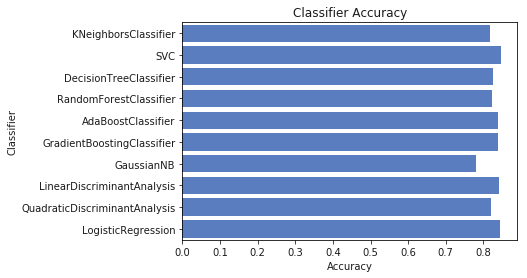

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [46]:
acc_dict

{'AdaBoostClassifier': 0.8377777777777776,
 'DecisionTreeClassifier': 0.8255555555555555,
 'GaussianNB': 0.7799999999999999,
 'GradientBoostingClassifier': 0.8388888888888889,
 'KNeighborsClassifier': 0.8166666666666667,
 'LinearDiscriminantAnalysis': 0.8422222222222222,
 'LogisticRegression': 0.8444444444444444,
 'QuadraticDiscriminantAnalysis': 0.82,
 'RandomForestClassifier': 0.8233333333333333,
 'SVC': 0.8477777777777777}

----
----
----
----

# original

https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/

# special

- cv 10
- less features
- not using columns = [train_df, test_df]
  - data_df = train_df.append(test_df)
  - train_df['Age'] = data_df['Age'][:891]
- **make a Title feature for imputing ages**
  - titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
    - Replacing rare titles with more common ones
      - mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss','Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
- **Adding Family_Survival**
  - **this feature express that other member of passenger's family are survived or not.**
    - **this feature doesn't include my survival count.**





# score

- best score of 10 cv score: **0.879492358564**
- submit score: 0.83253

# columns

	Survived	Pclass	Sex	Family_Size	Family_Survival
    
# else



In [5]:
# NumPy
import numpy as np

# Dataframe operations
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.linear_model import Perceptron
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [11]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
data_df = train_df.append(test_df) # The entire data: train + test.

data_df['Title'] = data_df['Name']
# Cleaning name and extracting Title
for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Age'] = data_df['Age'][:891]
test_df['Age'] = data_df['Age'][891:]

# Dropping Title feature
data_df.drop('Title', axis = 1, inplace = True)


data_df['Family_Size'] = data_df['Parch'] + data_df['SibSp']

# Substituting Age values in TRAIN_DF and TEST_DF:
train_df['Family_Size'] = data_df['Family_Size'][:891]
test_df['Family_Size'] = data_df['Family_Size'][891:]



data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

# group of same family
for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            
            # If any family memebers survived, put this feature as 1
            # Otherwise if any family memebers perished, put this feature as 0
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])


# also, group of same friends. they have same Ticket feature.
for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]


data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

train_df.drop(['Fare'], 1, inplace=True)
test_df.drop(['Fare'], 1, inplace=True)




data_df['AgeBin'] = pd.qcut(data_df['Age'], 4)

label = LabelEncoder()
data_df['AgeBin_Code'] = label.fit_transform(data_df['AgeBin'])

train_df['AgeBin_Code'] = data_df['AgeBin_Code'][:891]
test_df['AgeBin_Code'] = data_df['AgeBin_Code'][891:]

train_df.drop(['Age'], 1, inplace=True)
test_df.drop(['Age'], 1, inplace=True)



train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked'], axis = 1, inplace = True)
test_df.drop(['Name','PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
              'Embarked'], axis = 1, inplace = True)


Number of passengers with family survival information: 420
Number of passenger with family/group survival information: 546


In [5]:
train_df.head(3)


,Survived,Pclass,Sex,Family_Size,Family_Survival,FareBin_Code,AgeBin_Code
0,0,3,0,1,0.5,0,0
1,1,1,1,1,0.5,4,3
2,1,3,1,0,0.5,1,1


In [7]:
X = train_df.drop('Survived', 1)
y = train_df['Survived']
X_test = test_df.copy()


std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
X_test = std_scaler.transform(X_test)



n_neighbors = [6,7,8,9,10,11,12,14,16,18,20,22]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = list(range(1,50,5))
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, 
                cv=10, scoring = "roc_auc", n_jobs=3)
gd.fit(X, y)
print(gd.best_score_)
print(gd.best_estimator_)

gd.best_estimator_.fit(X, y)
y_pred = gd.best_estimator_.predict(X_test)



Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=3)]: Done 766 tasks      | elapsed:    3.2s


0.879492358564122
KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform')


[Parallel(n_jobs=3)]: Done 2400 out of 2400 | elapsed:    7.6s finished


----
----
----
----



# original

https://www.kaggle.com/francksylla/titanic-machine-learning-from-disaster

# points

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn import cross_validation
import re
import operator
from sklearn.feature_selection import SelectKBest, f_classif

#Print you can execute arbitrary python code
train = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
test = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )

target = train["Survived"].values
full = pd.concat([train, test])
#print(full.head())
#print(full.describe())
#print(full.info())

full['surname'] = full["Name"].apply(lambda x: x.split(',')[0].lower())

full["Title"] = full["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
full["TitleCat"] = full.loc[:,'Title'].map(title_mapping)

full["FamilySize"] = full["SibSp"] + full["Parch"] + 1
full["FamilySize"] = pd.cut(full["FamilySize"], bins=[0,1,4,20], labels=[0,1,2])

full["NameLength"] = full["Name"].apply(lambda x: len(x))

full["Embarked"] = pd.Categorical.from_array(full.Embarked).codes

full["Fare"] = full["Fare"].fillna(8.05)

full = pd.concat([full,pd.get_dummies(full['Sex'])],axis=1)

full['CabinCat'] = pd.Categorical.from_array(full.Cabin.fillna('0').apply(lambda x: x[0])).codes

# function to get oven/odd/null from cabine 
def get_type_cabine(cabine):
    # Use a regular expression to search for a title. 
    cabine_search = re.search('\d+', cabine)
    # If the title exists, extract and return it.
    if cabine_search:
        num = cabine_search.group(0)
        if np.float64(num) % 2 == 0:
            return '2'
        else:
            return '1'
    return '0'
full["Cabin"] = full["Cabin"].fillna(" ")

full["CabinType"] = full["Cabin"].apply(get_type_cabine)
#print(pd.value_counts(full["CabinType"]))



#### CHILD/FEMALE ADULT/MALE ADULT------------------------------------------------------------
child_age = 18
def get_person(passenger):
    age, sex = passenger
    if (age < child_age):
        return 'child'
    elif (sex == 'female'):
        return 'female_adult'
    else:
        return 'male_adult'
full = pd.concat([full, pd.DataFrame(full[['Age', 'Sex']].apply(get_person, axis=1), columns=['person'])],axis=1)
full = pd.concat([full,pd.get_dummies(full['person'])],axis=1)

### FEATURES BASED ON TICKET   --------------------------------------------------------
table_ticket = pd.DataFrame(full["Ticket"].value_counts())
table_ticket.rename(columns={'Ticket':'Ticket_Members'}, inplace=True)

table_ticket['Ticket_perishing_women'] = full.Ticket[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_ticket['Ticket_perishing_women'] = table_ticket['Ticket_perishing_women'].fillna(0)
table_ticket['Ticket_perishing_women'][table_ticket['Ticket_perishing_women'] > 0] = 1.0 

table_ticket['Ticket_surviving_men'] = full.Ticket[(full.male_adult == 1.0) 
                                    & (full.Survived == 1.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1.0 

table_ticket["Ticket_Id"]= pd.Categorical.from_array(table_ticket.index).codes
# compress under 3 members into one code.
table_ticket["Ticket_Id"][table_ticket["Ticket_Members"] < 3 ] = -1
table_ticket["Ticket_Members"] = pd.cut(table_ticket["Ticket_Members"], bins=[0,1,4,20], labels=[0,1,2])

full = pd.merge(full, table_ticket, left_on="Ticket",right_index=True,how='left', sort=False)

### FEATURES BASED ON SURNAME    --------------------------------------------------------
table_surname = pd.DataFrame(full["surname"].value_counts())
table_surname.rename(columns={'surname':'Surname_Members'}, inplace=True)

table_surname['Surname_perishing_women'] = full.surname[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_surname['Surname_perishing_women'] = table_surname['Surname_perishing_women'].fillna(0)
table_surname['Surname_perishing_women'][table_surname['Surname_perishing_women'] > 0] = 1.0 

table_surname['Surname_surviving_men'] = full.surname[(full.male_adult == 1.0) 
                                    & (full.Survived == 1.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1.0 

table_surname["Surname_Id"]= pd.Categorical.from_array(table_surname.index).codes
# compress under 3 members into one code.
table_surname["Surname_Id"][table_surname["Surname_Members"] < 3 ] = -1

table_surname["Surname_Members"] = pd.cut(table_surname["Surname_Members"], bins=[0,1,4,20], labels=[0,1,2])

full = pd.merge(full, table_surname, left_on="surname",right_index=True,how='left', sort=False)

### AGE PROCESSING --------------------------------------------------------------------------
classers = ['Fare','Parch','Pclass','SibSp','TitleCat', 
'CabinCat','female','male', 'Embarked', 'FamilySize', 'NameLength','Ticket_Members','Ticket_Id']
etr = ExtraTreesRegressor(n_estimators=200)
X_train = full[classers][full['Age'].notnull()]
Y_train = full['Age'][full['Age'].notnull()]
X_test = full[classers][full['Age'].isnull()]
etr.fit(X_train,np.ravel(Y_train))
age_preds = etr.predict(X_test)
full['Age'][full['Age'].isnull()] = age_preds

# FEATURES -----------------------------------------------------------------------------------
features = ['female','male','Age','male_adult','female_adult', 'child','TitleCat', 'Pclass',
'Pclass','Ticket_Id','NameLength','CabinType','CabinCat', 'SibSp', 'Parch',
'Fare','Embarked','Surname_Members','Ticket_Members','FamilySize',
'Ticket_perishing_women','Ticket_surviving_men',
'Surname_perishing_women','Surname_surviving_men']

train = full[0:891].copy()
test = full[891:].copy()

selector = SelectKBest(f_classif, k=len(features))
selector.fit(train[features], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],features[indices[f]]))

# BEST CLASSIFIER METHOD ==> RANDOM FOREST -----------------------------------------------------
rfc = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745,1:0.255})


# CROSS VALIDATION WITH RANDOM FOREST CLASSIFIER METHOD-----------------------------------------
kf = cross_validation.KFold(train.shape[0], n_folds=3, random_state=1)

scores = cross_validation.cross_val_score(rfc, train[features], target, cv=kf)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean()*100, scores.std()*100, 'RFC Cross Validation'))
rfc.fit(train[features], target)
score = rfc.score(train[features], target)
print("Accuracy: %0.3f            [%s]" % (score*100, 'RFC full test'))
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f]+1, importances[indices[f]]*100, features[indices[f]]))


# PREDICTION  -----------------------------------------------------------------------------------
rfc.fit(train[features], target)
predictions = rfc.predict(test[features])

# OUTPUT FILE -----------------------------------------------------------------------------------
PassengerId =np.array(test["PassengerId"]).astype(int)
my_prediction = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])

#my_prediction.to_csv("my_prediction.csv", index_label = ["PassengerId"])

print("The end ...")

/home/yuki/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a cop

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Features importance :
68.85 female
68.85 male
64.90 male_adult
53.23 female_adult
26.22 TitleCat
24.60 Pclass
24.60 Pclass
23.69 NameLength
17.75 CabinCat
17.00 Ticket_surviving_men
16.28 CabinType
14.21 Fare
13.54 Ticket_perishing_women
13.04 Surname_surviving_men
10.36 Surname_perishing_women
6.94 Embarked
5.27 Ticket_Members
3.59 child
2.93 FamilySize
1.83 Parch
1.79 Age
1.07 Ticket_Id
0.73 Surname_Members
0.53 SibSp
Accuracy: 89.675 (+/- 0.88) [RFC Cross Validation]
Accuracy: 96.296            [RFC full test]
1. feature 3 (9.065882) Age
2. feature 16 (8.847920) Fare
3. feature 11 (8.524511) NameLength
4. feature 21 (7.702126) Ticket_perishing_women
5. feature 7 (6.984746) TitleCat
6. feature 2 (6.805425) male
7. feature 23 (6.511190) Surname_perishing_women
8. feature 1 (5.858741) female
9. feature 4 (4.639197) male_adult
10. feature 22 (4.528991) Ticket_surviving_men
11. feature 9 (3.971880) Pclass
12. feature 8 (3.825686) Pclass
13. feature 5 (3.749371) female_adult
14. feature 1